In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

from net.layers import Dense, Reshape, Conv, ConvTranspose, ConvResBlock
from net.activations import Tanh, ReLU, Softmax
from net.losses import MSE, BinaryCrossEntropy
from net.optimizers import SGD, RMSprop
from net.initializers import Xavier
from net.utils import create_model, train, test, forward

2023-12-08 23:37:55.037345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# some helpers for loading MNIST
def to_categorical(labels):
    cats = np.unique(labels)
    categorical_labels = np.zeros((len(labels), len(cats)))
    for j in range(len(labels)):
        idx = 0
        while sum(categorical_labels[j]) == 0:
            if labels[j] == cats[idx]:
                categorical_labels[j][idx] = 1.0
            idx += 1
    return categorical_labels

def load_data(n):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32')
    x_train /= 255
    x_train = x_train.reshape(len(x_train), 28, 28, 1)
    y_train = to_categorical(y_train)

    x_test = x_test.astype('float32')
    x_test = x_test.reshape(len(x_test), 28, 28, 1)
    x_test /= 255
    y_test = to_categorical(y_test)

    return x_train[:n], y_train[:n], x_test, y_test

In [3]:
cae = create_model([
    Conv(1, (3,3), input_shape = (28, 28, 1), output_shape = (26, 26, 1)),
    Tanh(),
    Conv(1, (3,3), input_shape = (26, 26, 1), output_shape = (24, 24, 1)),
    Tanh(),
    Conv(1, (5,5), input_shape = (24, 24, 1), output_shape = (20, 20, 1)),
    Tanh(),
    ConvTranspose(1, (5,5), input_shape = (20, 20, 1), output_shape = (24, 24, 1)),
    Tanh(),
    ConvTranspose(1, (3,3), input_shape = (24, 24, 1), output_shape = (26, 26, 1)),
    Tanh(),
    ConvTranspose(1, (3,3), input_shape = (26, 26, 1), output_shape = (28, 28, 1)),
], Xavier(), RMSprop, {'learning_rate': 0.1})
loss = MSE()

x_train, y_train, x_test, y_test = load_data(2000)
train(cae, loss, x_train, x_train, epochs=50)
print('error on test set:', test(cae, loss, x_test, x_test))


1/50, error=0.040724
2/50, error=0.016081
3/50, error=0.014012
4/50, error=0.013156
5/50, error=0.012657
6/50, error=0.012287
7/50, error=0.011929
8/50, error=0.011561
9/50, error=0.011549
10/50, error=0.011603
11/50, error=0.011289
12/50, error=0.011407
13/50, error=0.011487
14/50, error=0.011369
15/50, error=0.011336
16/50, error=0.011414
17/50, error=0.011475
18/50, error=0.011359
19/50, error=0.011305
20/50, error=0.011452
21/50, error=0.011320
22/50, error=0.011399
23/50, error=0.011361
24/50, error=0.011352
25/50, error=0.011283
26/50, error=0.011249
27/50, error=0.011181
28/50, error=0.011339
29/50, error=0.011237
30/50, error=0.011257
31/50, error=0.011275
32/50, error=0.011293
33/50, error=0.011384
34/50, error=0.011253
35/50, error=0.011247
36/50, error=0.011415
37/50, error=0.011418
38/50, error=0.011184
39/50, error=0.011280
40/50, error=0.011219
41/50, error=0.011309
42/50, error=0.011291
43/50, error=0.011155
44/50, error=0.011219
45/50, error=0.011308
46/50, error=0.0112

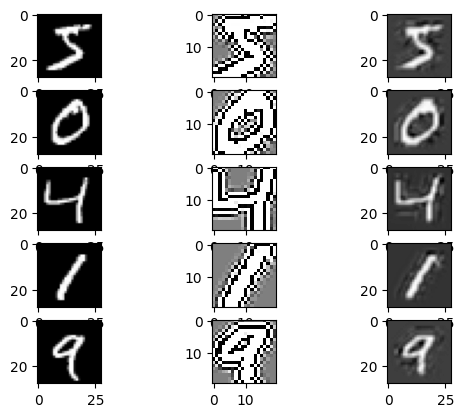

In [4]:
encoder = cae[:6]
decoder = cae[6:]
n = 20
f, ax = plt.subplots(5, 3)
for i in range(5):
    code, transport1 = forward(encoder, x_train[i])
    reconstructed = forward(decoder, code)[0][:,:,0]
    ax[i][0].imshow(x_train[i], cmap='gray')
    ax[i][1].imshow(code[:,:,0], cmap='gray')
    ax[i][2].imshow(reconstructed, cmap='gray')
plt.show()

In [6]:
encoded_train = []
for x in x_train:
    encoded_train.append(forward(encoder, x)[0])
    
encoded_test = []
for x in x_test:
    encoded_test.append(forward(encoder, x)[0])

In [24]:
lap_classifier = create_model([
    ConvResBlock((3,3), input_shape=(n,n,1), output_shape=(n,n,1)),
    ConvResBlock((3,3), input_shape=(n,n,1), output_shape=(n,n,1)),
    Reshape((1,n**2)),
    Dense(128),
    Tanh(),
    Dense(10),
    Softmax()
], Xavier(), SGD, {'learning_rate': 0.1})
mse = MSE()

x_train, y_train, x_test, y_test = load_data(1000)
lmbda = 15
print('error here includes some measure of average transport costs')
train(lap_classifier, mse, encoded_train, y_train, epochs=15, lmbda=lmbda)
# print('error on test set:', test(lap_classifier, mse, encoded_test, y_test))



error here includes some measure of average transport costs
1/30, error=0.859363
2/30, error=0.808349
3/30, error=0.827060
4/30, error=0.890868
5/30, error=0.980687
6/30, error=1.102384
7/30, error=1.329410
8/30, error=2.023549
9/30, error=5.092192
10/30, error=9.033823
11/30, error=10.414548
12/30, error=10.551433
13/30, error=10.671166
14/30, error=11.111148
15/30, error=11.688280
16/30, error=12.132697
17/30, error=12.478970
18/30, error=12.890666
19/30, error=13.308646
20/30, error=13.529012
21/30, error=13.708710
22/30, error=13.958081
23/30, error=14.280458
24/30, error=14.446069
25/30, error=14.595025
26/30, error=14.774576
27/30, error=14.927238
28/30, error=15.050307
29/30, error=15.214148
30/30, error=15.327052


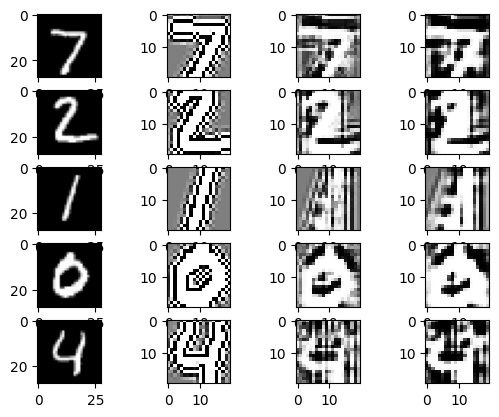

In [28]:
f, ax = plt.subplots(5, 4)
for i in range(5):
    code = forward(encoder, x_test[i])[0]
    # reconstructed = forward(decoder, code)[0]
    block1 = forward(lap_classifier[:1], code)[0]
    block2 = forward(lap_classifier[:2], code)[0]
    ax[i][0].imshow(x_test[i], cmap='gray')
    ax[i][1].imshow(code[:,:,0], cmap='gray')
    ax[i][2].imshow(block1[:,:,0], cmap='gray')
    ax[i][3].imshow(block2[:,:,0], cmap='gray')

plt.show()

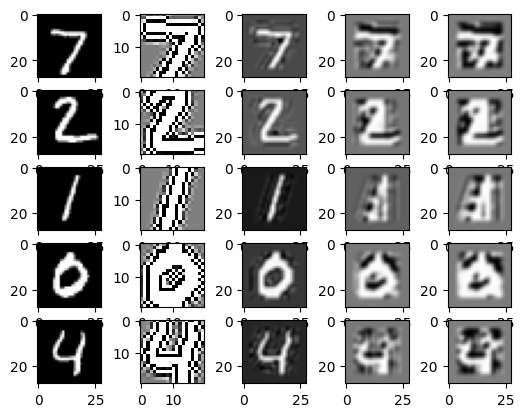

In [27]:
f, ax = plt.subplots(5, 5)
for i in range(5):
    code = forward(encoder, x_test[i])[0]
    block1 = forward(lap_classifier[:1], code)[0]
    block2 = forward(lap_classifier[:2], code)[0]
    reconstructed1 = forward(decoder, code)[0]
    reconstructed2 = forward(decoder, block1)[0]
    reconstructed3 = forward(decoder, block2)[0]
    # reconstructed6 = forward(decoder, forward(model2[:5], code1)[0].reshape(1,16))[0]
    ax[i][0].imshow(x_test[i], cmap='gray')
    ax[i][1].imshow(code[:,:,0], cmap='gray')
    ax[i][2].imshow(reconstructed1[:,:,0], cmap='gray')
    ax[i][3].imshow(reconstructed2[:,:,0], cmap='gray')
    ax[i][4].imshow(reconstructed3[:,:,0], cmap='gray')

plt.show()

In [29]:
error = 0
transports = 0
for x, y in zip(encoded_test, y_test):
    (output, transport) = forward(lap_classifier, x)
    transports+= transport
    error += loss.call(y, output[0]) #+ lmbda * transport
error /= len(x_test)
transports /= len(x_test)

print('classification error = %f, average transport cost across residual blocks = %f ' % (error, transports/lmbda))

classification error = 0.039302, average transport cost across residual blocks = 0.305247 
